# Recognizing Car Models using Neural Networks

In [35]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image

## Directory Format

```
./project.ipynb
./input/
    anno_test.csv
    anno_train.csv
    names.csv
    car_data/
```

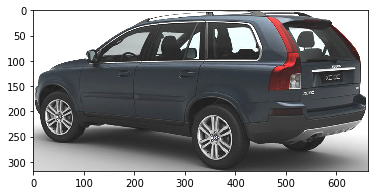

In [36]:
image = Image.open('./input/car_data/train/Volvo XC90 SUV 2007/00954.jpg')

box = (22, 12, 685, 330)
image = image.crop(box)
imgplot = plt.imshow(image)
plt.show()

In [37]:
MAX_LEN = 2648
MAX_WIDTH = 4156

In [66]:
image.thumbnail((512, 512), Image.ANTIALIAS)

arr = np.array(image)

shape = arr.shape
arr = np.pad(arr, ((0, 512 - shape[0]), (0, 512 - shape[1]), (0, 0)), 'constant')

im = Image.fromarray(arr)
if not os.path.exists(os.path.dirname('./output_dir/hello/1.jpg')):
    os.makedirs(os.path.dirname('./output_dir/hello/1.jpg'))
im.save('./output_dir/hello/1.jpg', format='JPEG')

In [30]:
img_arr = np.array(image)
img_arr.shape

bw = image.convert('L')
# bw.show()

bw_arr = np.array(bw)
bw_arr.shape

# shape = img_arr.shape
# img_arr = np.pad(img_arr, ((0, MAX_LEN - shape[0]), (0, MAX_WIDTH - shape[1]), (0, 0)), 'constant')

# rotated_arr = np.rot90(img_arr, 2)
# rotated_arr.shape

shape = bw_arr.shape
bw_arr = np.pad(bw_arr, ((0, MAX_LEN - shape[0]), (0, MAX_WIDTH - shape[1])), 'constant')
bw_arr.shape

if len(bw_arr.shape) < 3:
    print(bw_arr.shape)
    bw_arr = np.stack((bw_arr,) * 3, axis=-1)
    
bw_arr.shape

# img = Image.fromarray(bw_arr)
# img.show()

(2648, 4156)


(2648, 4156, 3)

In [38]:
anno_train_df = pd.read_csv('./input/anno_train.csv', header=None)
anno_test_df = pd.read_csv('./input/anno_test.csv', header=None)
names_df = pd.read_csv('./input/names.csv', header=None)

In [39]:
anno_test_df.head()

,0,1,2,3,4,5
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [40]:
anno_test_df.head()

,0,1,2,3,4,5
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [41]:
names_df.head()

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [42]:
names_df.size

196

In [43]:
car_data_dir = './input/car_data/'
train_dir = car_data_dir + 'train/'
test_dir = car_data_dir + 'test/'

In [44]:
def img_to_np_arr(img, box=None):
    if box is not None:
        img = img.crop(box)
    img_arr = np.array(img)
    
    # if image is grayscale, turn it to three channels
    if len(img_arr.shape) < 3:
        img_arr = change_img_to_3_channels(img_arr)
    return img_arr

In [45]:
def change_img_to_3_channels(img_arr):
    stacked_arr = np.stack((img_arr,) * 3, axis=-1)
    return stacked_arr

In [67]:
def save_img(filepath, img):
    if not os.path.exists(os.path.dirname(filepath)):
        os.makedirs(os.path.dirname(filepath))
    img.save(filepath, format='JPEG')

### Transforming Images to Numpy Arrays

In [46]:
train_imgs_np_arr, train_labels_np_arr, test_imgs_np_arr, test_labels_np_arr = [], [], [], []

In [47]:
def images_to_np_array(img_lst, label_lst, input_dir, test=False):
    for subdir, dirs, files in os.walk(input_dir):
        for f in files:
            if f == '.DS_Store':
                continue
            img_path = os.path.join(subdir, f)
            img = Image.open(img_path)
            
            row = anno_train_df.loc[anno_train_df[0] == f]
            label = row[5]
            # turn image to 3d numpy array
            img_arr = img_to_np_arr(img)
            
            img_lst.append(img_arr)
            label_lst.append(label)
            if not test:
                rotated = img.transpose(Image.ROTATE_180)
                rotated_img_arr = img_to_np_arr(rotated)
                img_lst.append(rotated_img_arr)
                label_lst.append(label)

In [49]:
images_to_np_array(train_imgs_np_arr, train_labels_np_arr, train_dir)
images_to_np_array(test_imgs_np_arr, test_labels_np_arr, test_dir, test=True)

Now `train_imgs_np_arr` and `test_imgs_np_arr` have all the train/test images represented in the form of 2d numpy arrays.

### Transforming Images by Cropping and Padding Zeroes

In [48]:
train_imgs_pad, train_labels_pad, test_imgs_pad, test_labels_pad = [], [], [], []

1. Crop
2. Resize to 512 x 512 based on the ratio
3. Pad the to 512 x 512
4. Write to file

In [68]:
def crop_images_and_pad(img_lst, label_lst, input_dir, test=False):
    for subdir, dirs, files in os.walk(input_dir):
        for f in files:
            if f == '.DS_Store':
                continue
            img_path = os.path.join(subdir, f)
            img = Image.open(img_path)
            
            # change size to 512 * width or height * 512
            img.thumbnail((512, 512), Image.ANTIALIAS)
            
            row = anno_train_df.loc[anno_train_df[0] == f]
            box = (row[1], row[2], row[3], row[4])
            label = row[5]
            
            img_arr = img_to_np_arr(img, box)
            shape = img_arr.shape
            # pad the image with zeroes to make it 512 * 512
            try:
                img_arr = np.pad(img_arr, ((0, 512 - shape[0]), (0, 512 - shape[1]), (0, 0)), 'constant')
            except ValueError:
                # should never happen now
                img_arr = np.pad(img_arr, ((0, 512 - shape[0]), (0, 512 - shape[1])), 'constant')
            
            img_lst.append(img_arr)
            label_lst.append(label)
            if not test:
                rotated_arr = np.rot90(img_arr, 2)
                img_lst.append(rotated_arr)
                label_lst.append(label)
                
            path = subdir.split('/')
            output_prefix = "./output_test/%s/%s" if test else "./output_train/%s/%s"
            output_path = output_prefix % (path[-1], f)
            save_img(Image.fromarray(img_arr), output_path)

In [ ]:
# might cause kernal to stop
crop_images_and_pad(train_imgs_pad, train_labels_pad, train_dir)
crop_images_and_pad(test_imgs_pad, test_labels_pad, test_dir, test=True)

Now `train_imgs_pad` and `test_imgs_pad` have all the train/test images represented in the form of greyscale 2d numpy arrays (padded with zeroes).

### Transforming Images by Cropping and Resizing

In [50]:
train_imgs_resized, train_labels_resized, test_imgs_resized, test_labels_resized = [], [], [], []

In [51]:
def crop_images_and_resize(img_lst, label_lst, input_dir, test=False):
    for subdir, dirs, files in os.walk(input_dir):
        for f in files:
            if f == '.DS_Store':
                continue
            img_path = os.path.join(subdir, f)
            img = Image.open(img_path)
            
            row = anno_train_df.loc[anno_train_df[0] == f]
            box = (row[1], row[2], row[3], row[4])
            label = row[5]
            img = img.crop(box)
            # resize here
            img_resized = img.resize((MAX_LEN, MAX_WIDTH), Image.ANTIALIAS)
            
            img_lst.append(img_resized)
            label_lst.append(label)
            if not test:
                rotated = img.transpose(Image.ROTATE_180)
                rotated = rotated.resize((MAX_LEN, MAX_WIDTH), Image.ANTIALIAS)
                img_lst.append(rorated)
                label_lst.append(label)

In [ ]:
# might cause kernel to stop working
crop_images_and_resize(train_imgs_resized, train_labels_resized, train_dir)
crop_images_and_resize(test_imgs_resized, test_labels_resized, test_dir, test=True)

Now `train_imgs_resized` and `test_imgs_resized` have all the train/test images with same shape.